**Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

*This notebook contains all the sample code and solutions to the exercices in chapter 2.*

# Get the data

* https://www.kaggle.com/datasets
* https://archive.ics.uci.edu/ml/index.php
* https://registry.opendata.aws/
* https://data.europa.eu/euodp/en/home
* https://data.gov.lv/lv
* https://ec.europa.eu/eurostat/data/database   

**Note**: You may find little differences between the code outputs in the book and in these Jupyter notebooks: these slight differences are mostly due to the random nature of many training algorithms: although I have tried to make these notebooks' outputs as constant as possible, it is impossible to guarantee that they will produce the exact same output on every platform. Also, some data structures (such as dictionaries) do not preserve the item order. Finally, I fixed a few minor bugs (I added notes next to the concerned cells) which lead to slightly different results, without changing the ideas presented in the book.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
hsing = pd.read_csv("datasets/housing/housing.csv")
hsing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


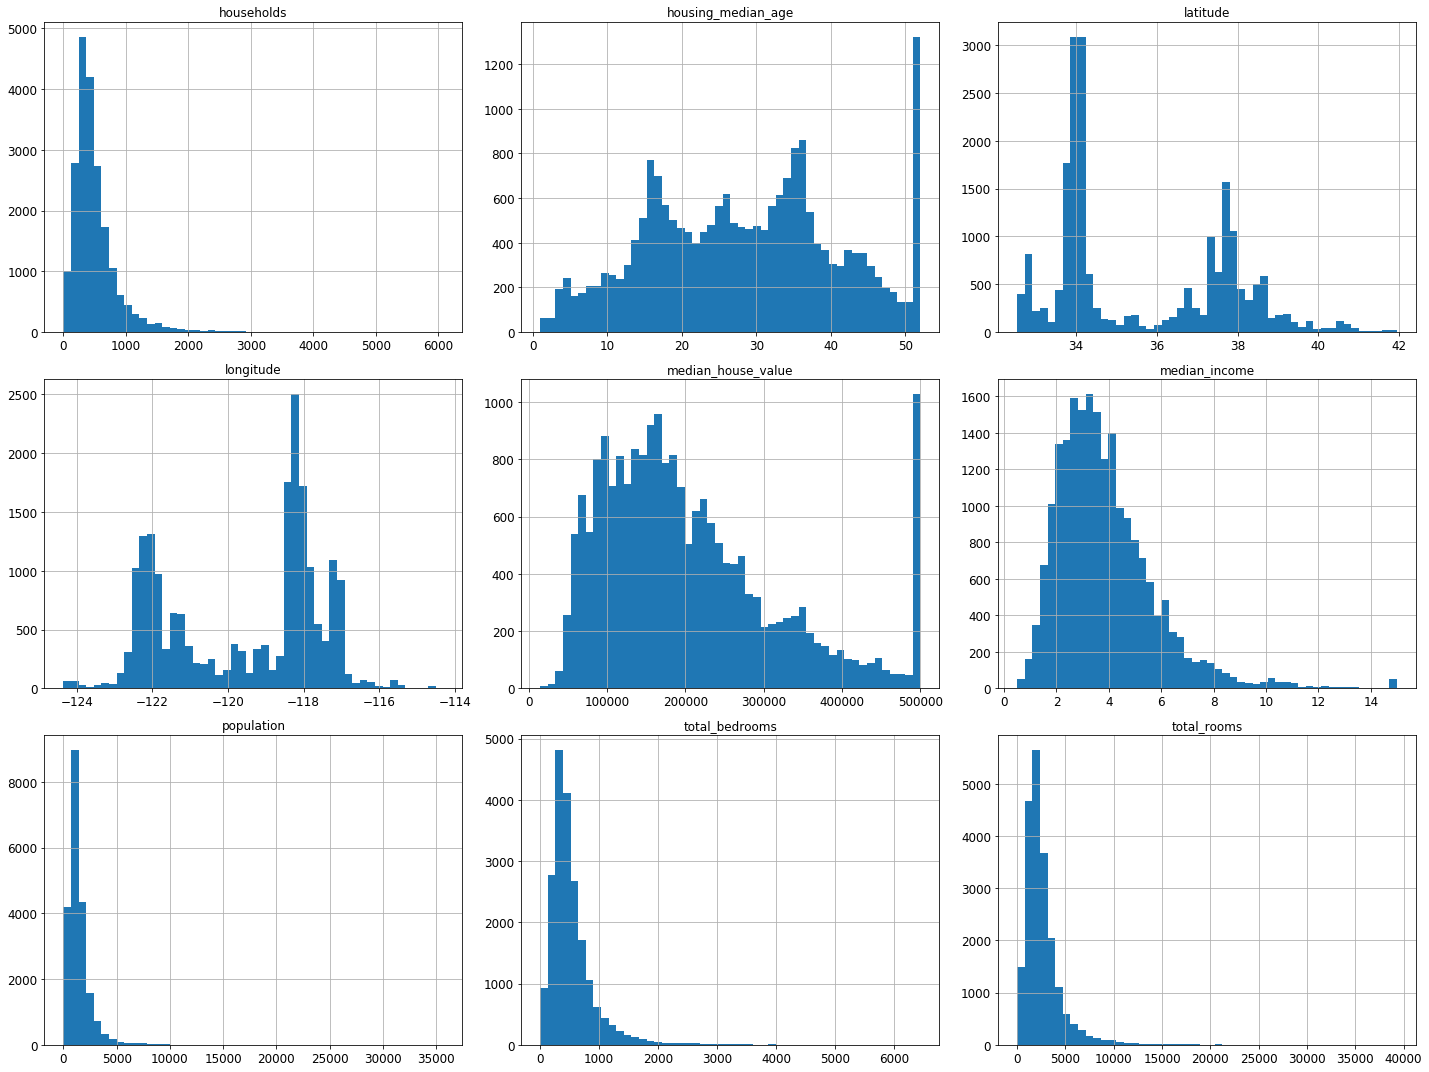

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [11]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [12]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
mydata = np.arange(100)
mydata[:5]

array([0, 1, 2, 3, 4])

In [15]:
train, test = split_train_test(mydata, 0.75)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [16]:
len(housing)

20640

In [17]:
mytrain, mytest = split_train_test(housing, 0.2)
len(mytrain),len(mytest)

(16512, 4128)

In [21]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [18]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

The implementation of `test_set_check()` above works fine in both Python 2 and Python 3. In earlier releases, the following implementation was proposed, which supported any hash function, but was much slower and did not support Python 2:

In [19]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

If you want an implementation that supports any hash function and is compatible with both Python 2 and Python 3, here is one:

In [20]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [21]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [22]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [23]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [24]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [25]:
housing.head(15)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [26]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [27]:
len(train_set)

16512

In [28]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


In [29]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


In [27]:
mytrain, mytest = train_test_split(mydata, test_size=0.25)

In [30]:
listtrain, listtest = train_test_split(list(range(100)), test_size=0.25)
len(listtest)

25

In [30]:
wtrain, wtest = train_test_split("kartupelis", test_size=0.25)
wtrain, wtest

(['k', 'e', 'a', 'r', 'i', 's', 'u'], ['p', 't', 'l'])

In [31]:
ntrain, ntest = train_test_split(range(100), test_size=0.2)
len(ntrain), len(ntest)

(80, 20)

In [32]:
ntrain[:10]

[92, 91, 44, 88, 69, 59, 40, 64, 77, 48]

In [33]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


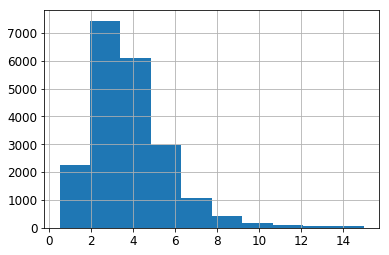

In [34]:
housing["median_income"].hist()

**Warning**: in the book, I did not use `pd.cut()`, instead I used the code below. The `pd.cut()` solution gives the same result (except the labels are integers instead of floats), but it is simpler to understand:

```python
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
```

In [35]:
# this is the recipe use to obtain new column binning some numberical column to our specifications
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               #labels=[1,2,3,4,5])
                               labels=["cheap", "affordable", "middle", "expensive", "very expensive"])

In [36]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,very expensive
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,very expensive
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,very expensive
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,expensive
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,middle


In [37]:
housing["income_bins"] = pd.cut(housing["median_income"], 5)
housing["income_bins"].value_counts()

(0.485, 3.4]    9683
(3.4, 6.3]      9088
(6.3, 9.2]      1488
(9.2, 12.1]      271
(12.1, 15.0]     110
Name: income_bins, dtype: int64

In [38]:
# if we want to cut in exactly the same size bins
housing["income_b"] = pd.qcut(housing["median_income"], 5)
housing["income_b"].value_counts()

(2.352, 3.141]    4131
(0.499, 2.352]    4130
(5.11, 15.0]      4128
(3.967, 5.11]     4128
(3.141, 3.967]    4123
Name: income_b, dtype: int64

In [39]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,income_bins,income_b
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,very expensive,"(6.3, 9.2]","(5.11, 15.0]"
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,very expensive,"(6.3, 9.2]","(5.11, 15.0]"
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,very expensive,"(6.3, 9.2]","(5.11, 15.0]"
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,expensive,"(3.4, 6.3]","(5.11, 15.0]"
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,middle,"(3.4, 6.3]","(3.141, 3.967]"


In [17]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

In [18]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,income_bins,income_b
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5,"(6.3, 9.2]","(5.11, 15.0]"
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5,"(6.3, 9.2]","(5.11, 15.0]"
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5,"(6.3, 9.2]","(5.11, 15.0]"
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4,"(3.4, 6.3]","(5.11, 15.0]"
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3,"(3.4, 6.3]","(3.141, 3.967]"


In [41]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,income_bins,income_b
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,very expensive,"(6.3, 9.2]","(5.11, 15.0]"
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,very expensive,"(6.3, 9.2]","(5.11, 15.0]"
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,very expensive,"(6.3, 9.2]","(5.11, 15.0]"
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,expensive,"(3.4, 6.3]","(5.11, 15.0]"
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,middle,"(3.4, 6.3]","(3.141, 3.967]"


In [42]:
from sklearn.model_selection import StratifiedShuffleSplit

# with this recipe we could potentionally split our origina data set in multiple sets many times
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [43]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

middle            0.350533
affordable        0.318798
expensive         0.176357
very expensive    0.114583
cheap             0.039729
Name: income_cat, dtype: float64

In [44]:
housing["income_cat"].value_counts() / len(housing)

middle            0.350581
affordable        0.318847
expensive         0.176308
very expensive    0.114438
cheap             0.039826
Name: income_cat, dtype: float64

In [45]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [46]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
cheap,0.039826,0.039729,0.040213,0.973236,-0.243309
affordable,0.318847,0.318798,0.324370,1.732260,-0.015195
middle,0.350581,0.350533,0.358527,2.266446,-0.013820
expensive,0.176308,0.176357,0.167393,-5.056334,0.027480
very expensive,0.114438,0.114583,0.109496,-4.318374,0.127011


In [47]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,income_bins,income_b
7776,-118.09,33.90,37.0,1112.0,222.0,771.0,224.0,4.2132,164600.0,<1H OCEAN,middle,"(3.4, 6.3]","(3.967, 5.11]"
2202,-119.86,36.82,12.0,1488.0,253.0,675.0,223.0,4.7622,89300.0,INLAND,expensive,"(3.4, 6.3]","(3.967, 5.11]"
537,-122.30,37.77,42.0,2038.0,368.0,2037.0,355.0,2.6447,200000.0,NEAR BAY,affordable,"(0.485, 3.4]","(2.352, 3.141]"
11698,-117.97,33.89,17.0,1851.0,344.0,764.0,339.0,5.1315,181800.0,<1H OCEAN,expensive,"(3.4, 6.3]","(5.11, 15.0]"
14141,-117.08,32.74,26.0,2359.0,622.0,2067.0,581.0,1.8103,124700.0,NEAR OCEAN,affordable,"(0.485, 3.4]","(0.499, 2.352]"


In [48]:
# here we simply drop the income_cat and income bins and income b for our trian and test sets
for set_ in (strat_train_set, strat_test_set):
    set_.drop(["income_cat", "income_bins", "income_b"], axis=1, inplace=True)

In [49]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
7776,-118.09,33.90,37.0,1112.0,222.0,771.0,224.0,4.2132,164600.0,<1H OCEAN
2202,-119.86,36.82,12.0,1488.0,253.0,675.0,223.0,4.7622,89300.0,INLAND
537,-122.30,37.77,42.0,2038.0,368.0,2037.0,355.0,2.6447,200000.0,NEAR BAY
11698,-117.97,33.89,17.0,1851.0,344.0,764.0,339.0,5.1315,181800.0,<1H OCEAN
14141,-117.08,32.74,26.0,2359.0,622.0,2067.0,581.0,1.8103,124700.0,NEAR OCEAN


# Discover and visualize the data to gain insights

In [50]:
housing = strat_train_set.copy()

Saving figure bad_visualization_plot


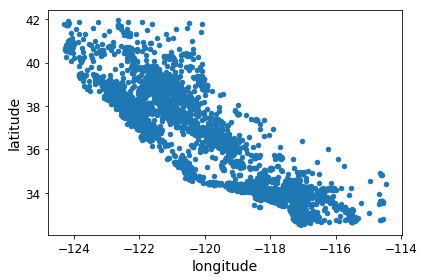

In [51]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


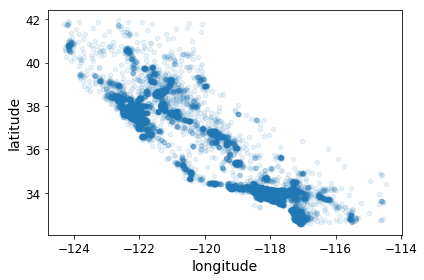

In [52]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611). Thanks to Wilmer Arellano for pointing it out.

Saving figure housing_prices_scatterplot


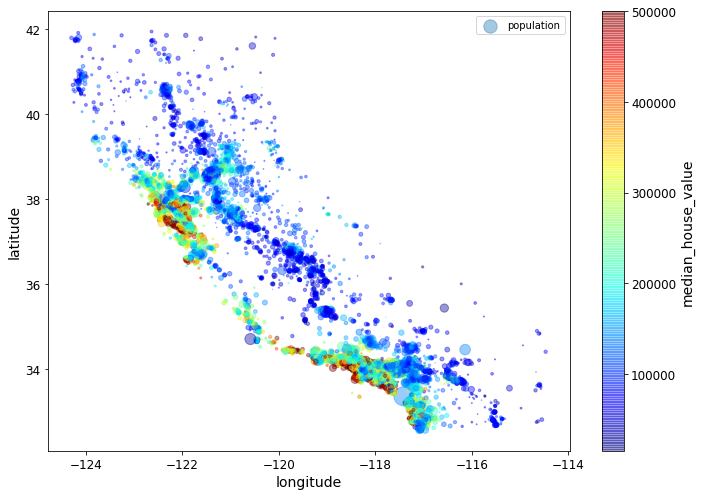

In [53]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

Saving figure california_housing_prices_plot


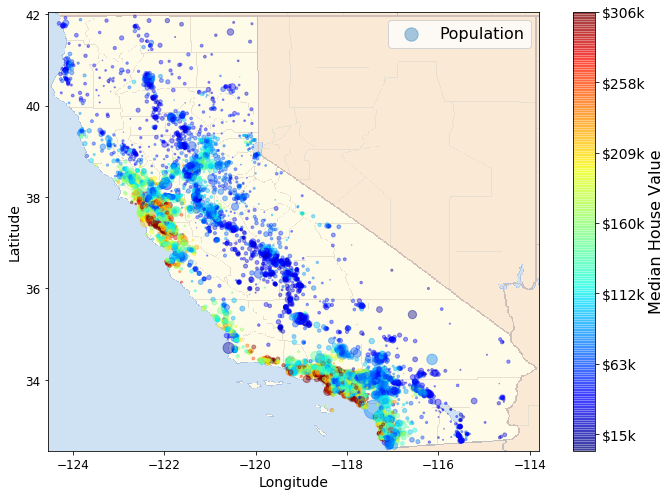

In [54]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
# so here we adjust the overlay image
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [56]:
# creating a correlation matrix
corr_matrix = housing.corr()

In [57]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687639
total_rooms           0.135759
housing_median_age    0.117697
households            0.066663
total_bedrooms        0.049342
population           -0.027056
longitude            -0.049523
latitude             -0.141100
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


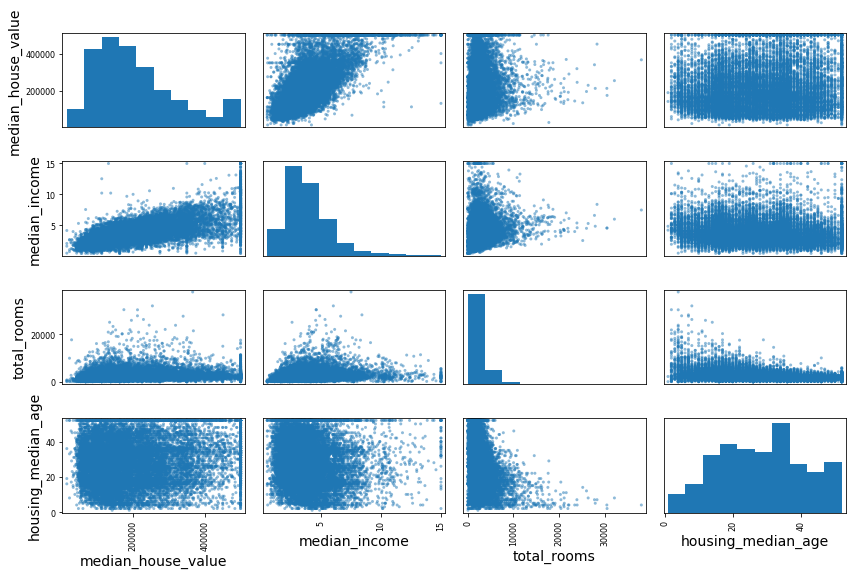

In [58]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [59]:
import seaborn as sb

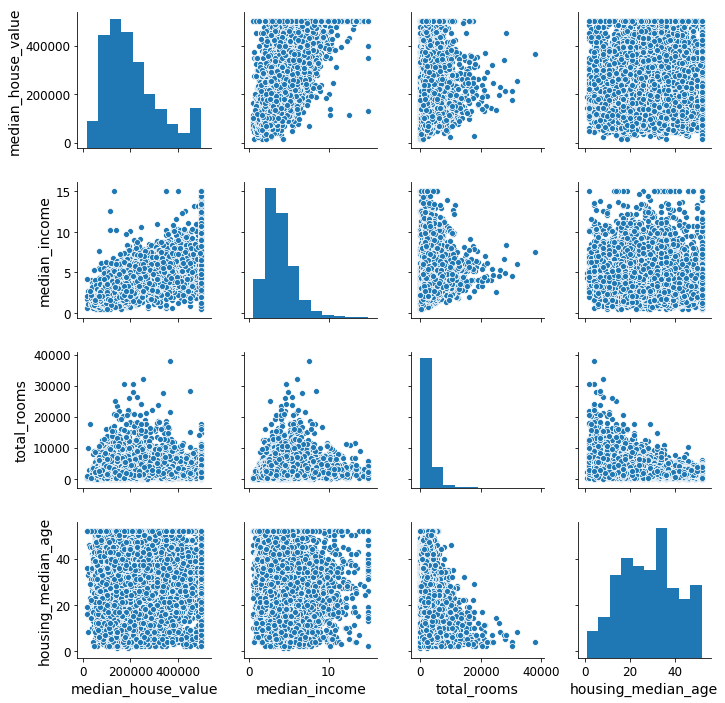

In [60]:
sb.pairplot(housing[attributes])

Saving figure income_vs_house_value_scatterplot


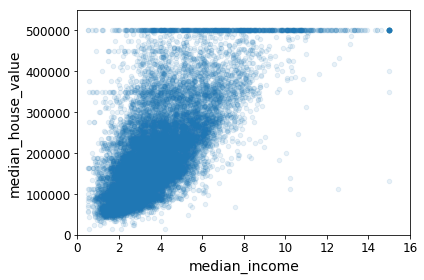

In [61]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

In [60]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,income_bins,income_b,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,2,"(0.485, 3.4]","(2.352, 3.141]",4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,5,"(6.3, 9.2]","(5.11, 15.0]",6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,2,"(0.485, 3.4]","(2.352, 3.141]",4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,2,"(0.485, 3.4]","(0.499, 2.352]",5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,3,"(0.485, 3.4]","(2.352, 3.141]",4.505810,0.231341,3.047847


In [62]:
# feature engineering
# using existing create new columns
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

Note: there was a bug in the previous cell, in the definition of the `rooms_per_household` attribute. This explains why the correlation value below differs slightly from the value in the book (unless you are reading the latest version).

In [63]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687639
rooms_per_household         0.147161
total_rooms                 0.135759
housing_median_age          0.117697
households                  0.066663
total_bedrooms              0.049342
population                 -0.027056
population_per_household   -0.027417
longitude                  -0.049523
latitude                   -0.141100
bedrooms_per_room          -0.261696
Name: median_house_value, dtype: float64

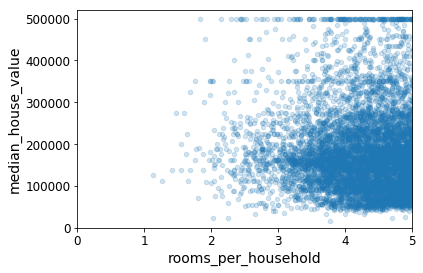

In [63]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [64]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
7776,-118.09,33.90,37.0,1112.0,222.0,771.0,224.0,4.2132,164600.0,<1H OCEAN,4.964286,0.199640,3.441964
2202,-119.86,36.82,12.0,1488.0,253.0,675.0,223.0,4.7622,89300.0,INLAND,6.672646,0.170027,3.026906
537,-122.30,37.77,42.0,2038.0,368.0,2037.0,355.0,2.6447,200000.0,NEAR BAY,5.740845,0.180569,5.738028
11698,-117.97,33.89,17.0,1851.0,344.0,764.0,339.0,5.1315,181800.0,<1H OCEAN,5.460177,0.185845,2.253687
14141,-117.08,32.74,26.0,2359.0,622.0,2067.0,581.0,1.8103,124700.0,NEAR OCEAN,4.060241,0.263671,3.557659


In [65]:
near_ocean = housing[housing['ocean_proximity'] == "NEAR OCEAN"]
near_ocean.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
14141,-117.08,32.74,26.0,2359.0,622.0,2067.0,581.0,1.8103,124700.0,NEAR OCEAN,4.060241,0.263671,3.557659
14850,-117.07,32.67,28.0,2758.0,623.0,2179.0,631.0,2.3814,112300.0,NEAR OCEAN,4.370840,0.225888,3.453249
16099,-122.51,37.76,43.0,2345.0,624.0,1439.0,614.0,2.8448,268900.0,NEAR OCEAN,3.819218,0.266098,2.343648
16836,-122.49,37.60,33.0,3507.0,669.0,1697.0,660.0,4.0795,270600.0,NEAR OCEAN,5.313636,0.190761,2.571212
14580,-117.19,32.82,35.0,1074.0,180.0,442.0,173.0,5.2530,204000.0,NEAR OCEAN,6.208092,0.167598,2.554913


In [66]:
oc_corr = near_ocean.corr()

In [67]:
oc_corr["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.705507
rooms_per_household         0.485576
total_rooms                 0.191236
latitude                    0.165897
housing_median_age          0.083762
total_bedrooms              0.050040
households                  0.042118
population                 -0.053317
longitude                  -0.218343
population_per_household   -0.230296
bedrooms_per_room          -0.424628
Name: median_house_value, dtype: float64

In [64]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Prepare the data for Machine Learning algorithms

In [69]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [71]:
# find any rows with missing values
all_incomplete_rows = housing[housing.isnull().any(axis=1)]
len(all_incomplete_rows)

167

In [67]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,income_bins,income_b


In [68]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity,income_cat,income_bins,income_b
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN,2,"(0.485, 3.4]","(0.499, 2.352]"
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN,4,"(3.4, 6.3]","(5.11, 15.0]"
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN,4,"(3.4, 6.3]","(3.967, 5.11]"
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND,2,"(0.485, 3.4]","(0.499, 2.352]"
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN,3,"(0.485, 3.4]","(3.141, 3.967]"


In [72]:
median = housing["total_bedrooms"].median()
median

436.0

In [73]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1097,-121.77,39.66,20.0,3759.0,436.0,1705.0,600.0,4.7120,INLAND
19607,-121.02,37.48,26.0,467.0,436.0,244.0,83.0,4.1346,INLAND
2028,-119.75,36.71,38.0,1481.0,436.0,1543.0,372.0,1.4577,INLAND
14986,-117.03,32.73,34.0,2061.0,436.0,1169.0,400.0,3.5096,NEAR OCEAN
19818,-119.30,36.57,32.0,728.0,436.0,461.0,149.0,3.0156,INLAND


**Warning**: Since Scikit-Learn 0.20, the `sklearn.preprocessing.Imputer` class was replaced by the `sklearn.impute.SimpleImputer` class.

In [74]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [75]:
housing_num = housing.drop('ocean_proximity', axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [76]:
# here i fit specific columns
imputer.fit(housing_num.iloc[:,:9])

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [77]:
imputer.statistics_

array([-118.5    ,   34.26   ,   29.     , 2130.5    ,  436.     ,
       1169.     ,  411.     ,    3.53225])

Check that this is the same as manually computing the median of each attribute:

In [78]:
housing_num.median().values

array([-118.5    ,   34.26   ,   29.     , 2130.5    ,  436.     ,
       1169.     ,  411.     ,    3.53225])

Transform the training set:

In [79]:
X = imputer.transform(housing_num.iloc[:,:9])

In [80]:
housing_num = housing_num.iloc[:,:9]
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
7776,-118.09,33.90,37.0,1112.0,222.0,771.0,224.0,4.2132
2202,-119.86,36.82,12.0,1488.0,253.0,675.0,223.0,4.7622
537,-122.30,37.77,42.0,2038.0,368.0,2037.0,355.0,2.6447
11698,-117.97,33.89,17.0,1851.0,344.0,764.0,339.0,5.1315
14141,-117.08,32.74,26.0,2359.0,622.0,2067.0,581.0,1.8103


In [81]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [82]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1097,-121.77,39.66,20.0,3759.0,436.0,1705.0,600.0,4.7120
19607,-121.02,37.48,26.0,467.0,436.0,244.0,83.0,4.1346
2028,-119.75,36.71,38.0,1481.0,436.0,1543.0,372.0,1.4577
14986,-117.03,32.73,34.0,2061.0,436.0,1169.0,400.0,3.5096
19818,-119.30,36.57,32.0,728.0,436.0,461.0,149.0,3.0156


In [83]:
imputer.strategy

'median'

In [84]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
7776,-118.09,33.90,37.0,1112.0,222.0,771.0,224.0,4.2132
2202,-119.86,36.82,12.0,1488.0,253.0,675.0,223.0,4.7622
537,-122.30,37.77,42.0,2038.0,368.0,2037.0,355.0,2.6447
11698,-117.97,33.89,17.0,1851.0,344.0,764.0,339.0,5.1315
14141,-117.08,32.74,26.0,2359.0,622.0,2067.0,581.0,1.8103


Now let's preprocess the categorical input feature, `ocean_proximity`:

In [85]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
7776,<1H OCEAN
2202,INLAND
537,NEAR BAY
11698,<1H OCEAN
14141,NEAR OCEAN
11792,INLAND
14850,NEAR OCEAN
19685,INLAND
3531,<1H OCEAN
18699,INLAND


**Warning**: earlier versions of the book used the `LabelEncoder` class or Pandas' `Series.factorize()` method to encode string categorical attributes as integers. However, the `OrdinalEncoder` class that was introduced in Scikit-Learn 0.20 (see [PR #10521](https://github.com/scikit-learn/scikit-learn/issues/10521)) is preferable since it is designed for input features (`X` instead of labels `y`) and it plays well with pipelines (introduced later in this notebook). If you are using an older version of Scikit-Learn (<0.20), then you can import it from `future_encoders.py` instead.

In [87]:
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20

In [88]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [1.],
       [3.],
       [0.],
       [4.],
       [1.],
       [4.],
       [1.],
       [0.],
       [1.]])

In [89]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

**Warning**: earlier versions of the book used the `LabelBinarizer` or `CategoricalEncoder` classes to convert each categorical value to a one-hot vector. It is now preferable to use the `OneHotEncoder` class. Since Scikit-Learn 0.20 it can handle string categorical inputs (see [PR #10521](https://github.com/scikit-learn/scikit-learn/issues/10521)), not just integer categorical inputs. If you are using an older version of Scikit-Learn, you can import the new version from `future_encoders.py`:

In [90]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [93]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [65]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [94]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Let's create a custom transformer to add extra attributes:

In [67]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [92]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Alternatively, you can use Scikit-Learn's `FunctionTransformer` class that lets you easily create a transformer based on a transformation function (thanks to [Hanmin Qin](https://github.com/qinhanmin2014) for suggesting this code). Note that we need to set `validate=False` because the data contains non-float values (`validate` will default to `False` in Scikit-Learn 0.22).

In [93]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [94]:
type(housing_extra_attribs)

numpy.ndarray

In [96]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
7776,-118.09,33.9,37,1112,222,771,224,4.2132,<1H OCEAN,4.96429,3.44196
2202,-119.86,36.82,12,1488,253,675,223,4.7622,INLAND,6.67265,3.02691
537,-122.3,37.77,42,2038,368,2037,355,2.6447,NEAR BAY,5.74085,5.73803
11698,-117.97,33.89,17,1851,344,764,339,5.1315,<1H OCEAN,5.46018,2.25369
14141,-117.08,32.74,26,2359,622,2067,581,1.8103,NEAR OCEAN,4.06024,3.55766


Now let's build a pipeline for preprocessing the numerical attributes (note that we could use `CombinedAttributesAdder()` instead of `FunctionTransformer(...)` if we preferred):

In [97]:
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
7776,-118.09,33.90,37.0,1112.0,222.0,771.0,224.0,4.2132
2202,-119.86,36.82,12.0,1488.0,253.0,675.0,223.0,4.7622
537,-122.30,37.77,42.0,2038.0,368.0,2037.0,355.0,2.6447
11698,-117.97,33.89,17.0,1851.0,344.0,764.0,339.0,5.1315
14141,-117.08,32.74,26.0,2359.0,622.0,2067.0,581.0,1.8103


In [98]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [99]:
len(housing_num_tr)

16512

In [101]:
housing_num_tr[:5]

array([[ 0.74150409, -0.81243412,  0.66713822, -0.70682631, -0.76004575,
        -0.58438519, -0.72905311,  0.17626988, -0.18654731,  0.03377698,
        -0.2184506 ],
       [-0.14401741,  0.55660144, -1.31986489, -0.53234514, -0.68525395,
        -0.67039814, -0.73170078,  0.46355504,  0.48245992, -0.00418245,
        -0.67919586],
       [-1.36473631,  1.00200684,  1.06453884, -0.27712002, -0.40780051,
         0.54991059, -0.38220809, -0.64450748,  0.11755944,  0.24376491,
        -0.51517162],
       [ 0.80153944, -0.8171226 , -0.92246427, -0.36389656, -0.46570383,
        -0.59065696, -0.42457084,  0.65680533,  0.00764761, -0.07489762,
        -0.43307935],
       [ 1.24680166, -1.35629756, -0.20714315, -0.12816136,  0.2050097 ,
         0.57678964,  0.21616577, -1.08113906, -0.54057835,  0.04435793,
         0.77778295]])

**Warning**: earlier versions of the book applied different transformations to different columns using a solution based on a `DataFrameSelector` transformer and a `FeatureUnion` (see below). It is now preferable to use the `ColumnTransformer` class that was introduced in Scikit-Learn 0.20. If you are using an older version of Scikit-Learn, you can import it from `future_encoders.py`:

In [103]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [104]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [105]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [105]:
housing_prepared.shape

(16512, 16)

In [106]:
housing_tr.shape

(16512, 8)

For reference, here is the old solution based on a `DataFrameSelector` transformer (to just select a subset of the Pandas `DataFrame` columns), and a `FeatureUnion`:

In [108]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features (again, we could use `CombinedAttributesAdder()` instead of `FunctionTransformer(...)` if we preferred):

In [109]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [110]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [111]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[ 0.74150409, -0.81243412,  0.66713822, ...,  0.        ,
         0.        ,  0.        ],
       [-0.14401741,  0.55660144, -1.31986489, ...,  0.        ,
         0.        ,  0.        ],
       [-1.36473631,  1.00200684,  1.06453884, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.71435329,  0.97387597,  1.85934009, ...,  0.        ,
         0.        ,  0.        ],
       [-0.67432972,  0.91761424, -0.20714315, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.27623008, -0.10447395, -0.60454377, ...,  0.        ,
         0.        ,  0.        ]])

The result is the same as with the `ColumnTransformer`:

In [81]:
np.allclose(housing_prepared, old_housing_prepared)

True

# Select and train a model 

In [112]:
type(housing_labels)

pandas.core.series.Series

In [113]:
housing_labels.head()

7776     164600.0
2202      89300.0
537      200000.0
11698    181800.0
14141    124700.0
Name: median_house_value, dtype: float64

In [114]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
# so here we finally fit our data
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [115]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [232353.87433805 165296.81980844 150784.35601724 258329.10558109
 136575.72768552]


In [117]:
print("Labels:", list(some_labels))

Labels: [164600.0, 89300.0, 200000.0, 181800.0, 124700.0]


Compare against the actual values:

In [116]:
some_data_prepared

array([[ 0.74150409, -0.81243412,  0.66713822, -0.70682631, -0.76004575,
        -0.58438519, -0.72905311,  0.17626988, -0.18654731,  0.03377698,
        -0.2184506 ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.14401741,  0.55660144, -1.31986489, -0.53234514, -0.68525395,
        -0.67039814, -0.73170078,  0.46355504,  0.48245992, -0.00418245,
        -0.67919586,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [-1.36473631,  1.00200684,  1.06453884, -0.27712002, -0.40780051,
         0.54991059, -0.38220809, -0.64450748,  0.11755944,  0.24376491,
        -0.51517162,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.80153944, -0.8171226 , -0.92246427, -0.36389656, -0.46570383,
        -0.59065696, -0.42457084,  0.65680533,  0.00764761, -0.07489762,
        -0.43307935,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.24680166, -1.35629756, -0

In [112]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [118]:
housing_labels.describe()

count     16512.000000
mean     207480.153161
std      116126.452849
min       14999.000000
25%      119875.000000
50%      179600.000000
75%      265600.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [85]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [116]:
len(housing_prepared)

16512

In [120]:
# we can computer our mean squared error for all data
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68689.44636734077

In [121]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49715.98087264053

In [122]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [124]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [125]:
housing_predictions.shape

(16512,)

In [126]:
housing_labels.shape

(16512,)

In [127]:
housing_predictions[:5]

array([164600.,  89300., 200000., 181800., 124700.])

In [128]:
housing_labels[:5]

7776     164600.0
2202      89300.0
537      200000.0
11698    181800.0
14141    124700.0
Name: median_house_value, dtype: float64

# Fine-tune your model

In [124]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [125]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70274.7991723  67258.3624668  71350.42593227 68882.91340979
 70987.99296566 74177.52037059 70788.57311306 70850.53018019
 76430.62239321 70212.6471067 ]
Mean: 71121.4387110585
Standard deviation: 2434.3080046605132


In [126]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66877.52325028 66608.120256   70575.91118868 74179.94799352
 67683.32205678 71103.16843468 64782.65896552 67711.29940352
 71080.40484136 67687.6384546 ]
Mean: 68828.99948449328
Standard deviation: 2662.7615706103393


**Note**: we specify `n_estimators=10` to avoid a warning about the fact that the default value is going to change to 100 in Scikit-Learn 0.22.

In [127]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [128]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22107.0888400092

In [130]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51481.61843757 48867.18698326 53592.93924497 54917.35753217
 50463.39403515 56776.52132037 51940.08691385 50521.84102811
 55729.5024898  53136.5656865 ]
Mean: 52742.701367175265
Standard deviation: 2412.0829538615826


In [131]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     68828.999484
std       2806.797143
min      64782.658966
25%      67078.972952
50%      67699.468929
75%      70954.281428
max      74179.947994
dtype: float64

In [132]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

106874.50415237377

In [133]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

The best hyperparameter combination found:

In [134]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [135]:
bestPred = grid_search.best_estimator_
bestPred

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [136]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64246.77949402578 {'max_features': 2, 'n_estimators': 3}
55869.738265789805 {'max_features': 2, 'n_estimators': 10}
53472.049050362606 {'max_features': 2, 'n_estimators': 30}
61376.21402981468 {'max_features': 4, 'n_estimators': 3}
53846.28747553631 {'max_features': 4, 'n_estimators': 10}
51270.16050804186 {'max_features': 4, 'n_estimators': 30}
59860.65599776349 {'max_features': 6, 'n_estimators': 3}
53114.388232043595 {'max_features': 6, 'n_estimators': 10}
50811.40364168747 {'max_features': 6, 'n_estimators': 30}
59220.32752543448 {'max_features': 8, 'n_estimators': 3}
52884.76688140635 {'max_features': 8, 'n_estimators': 10}
50944.352464380354 {'max_features': 8, 'n_estimators': 30}
62805.478464758075 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54462.05968306157 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61117.24602634563 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53022.92700857423 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [137]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.069930,0.013019,0.005393,0.003548,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.931932e+09,-4.108663e+09,...,-4.127649e+09,1.924798e+08,18,-1.114486e+09,-1.060851e+09,-1.105913e+09,-1.094676e+09,-1.133282e+09,-1.101842e+09,2.406866e+07
1,0.188750,0.015457,0.014353,0.007216,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.909367e+09,-3.120571e+09,...,-3.121428e+09,1.684400e+08,11,-5.759053e+08,-5.710866e+08,-5.772770e+08,-5.820883e+08,-5.967966e+08,-5.806308e+08,8.810527e+06
2,0.565818,0.034071,0.026536,0.002309,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.677180e+09,-2.901491e+09,...,-2.859260e+09,1.563662e+08,8,-4.385939e+08,-4.261753e+08,-4.364716e+08,-4.336798e+08,-4.521519e+08,-4.374145e+08,8.482200e+06
3,0.084125,0.002338,0.003447,0.000999,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.514530e+09,-3.714699e+09,...,-3.767040e+09,1.576908e+08,16,-9.783463e+08,-9.627673e+08,-9.841863e+08,-1.031772e+09,-1.008554e+09,-9.931251e+08,2.429626e+07
4,0.298395,0.028648,0.009391,0.001825,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.758664e+09,-2.966146e+09,...,-2.899423e+09,1.397413e+08,9,-5.340533e+08,-5.253397e+08,-5.299331e+08,-5.298511e+08,-5.321210e+08,-5.302596e+08,2.909844e+06
5,0.826412,0.034699,0.024954,0.001223,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.469417e+09,-2.730887e+09,...,-2.628629e+09,1.435115e+08,3,-4.023370e+08,-4.024745e+08,-4.028804e+08,-4.097805e+08,-4.081646e+08,-4.051274e+08,3.185886e+06
6,0.116394,0.005223,0.003590,0.000467,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.469825e+09,-3.777163e+09,...,-3.583298e+09,1.294963e+08,13,-9.272504e+08,-9.323462e+08,-9.092923e+08,-9.485986e+08,-9.375958e+08,-9.310167e+08,1.296387e+07
7,0.366371,0.004950,0.008559,0.000793,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.718094e+09,-2.860399e+09,...,-2.821138e+09,1.371620e+08,7,-5.176219e+08,-5.102643e+08,-5.036363e+08,-5.320044e+08,-5.129550e+08,-5.152964e+08,9.500832e+06
8,1.163874,0.040242,0.026781,0.002770,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.477282e+09,-2.632966e+09,...,-2.581799e+09,1.438148e+08,1,-3.969466e+08,-3.888514e+08,-3.956343e+08,-4.058589e+08,-3.912175e+08,-3.957017e+08,5.861017e+06
9,0.166399,0.020205,0.004418,0.001373,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.409629e+09,-3.627721e+09,...,-3.507047e+09,1.713295e+08,12,-9.121501e+08,-9.226590e+08,-8.740418e+08,-9.727259e+08,-8.892866e+08,-9.141727e+08,3.386559e+07


In [138]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BF14CCF128>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BF14CCF470>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [139]:
rnd_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=180, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [140]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49931.83370450304 {'max_features': 7, 'n_estimators': 180}
52122.26073885765 {'max_features': 5, 'n_estimators': 15}
51463.906813209505 {'max_features': 3, 'n_estimators': 72}
51381.385870076425 {'max_features': 5, 'n_estimators': 21}
50040.63743808166 {'max_features': 7, 'n_estimators': 122}
51436.763292635806 {'max_features': 3, 'n_estimators': 75}
51286.345451957626 {'max_features': 3, 'n_estimators': 88}
50312.57595748435 {'max_features': 5, 'n_estimators': 100}
50995.415279184126 {'max_features': 3, 'n_estimators': 150}
65455.38356204712 {'max_features': 5, 'n_estimators': 2}


In [141]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.79326113e-02, 6.18280724e-02, 4.33395023e-02, 1.81017027e-02,
       1.83291556e-02, 1.93269892e-02, 1.78369580e-02, 2.41360490e-01,
       1.61976585e-01, 5.35982558e-02, 1.06273526e-01, 6.14045141e-02,
       1.22353255e-02, 1.08821239e-01, 2.76143239e-05, 2.59938294e-03,
       5.00807682e-03])

In [147]:
# http://omz-software.com/pythonista/numpy/reference/generated/numpy.argmax.html
feature_importances.argmax()

7

In [148]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.24136048955382883, 'median_income'),
 (0.16197658459849276, 'income_cat'),
 (0.10882123891274476, 'INLAND'),
 (0.10627352591969835, 'pop_per_hhold'),
 (0.06793261134305181, 'longitude'),
 (0.06182807241916786, 'latitude'),
 (0.061404514078416045, 'bedrooms_per_room'),
 (0.05359825584988402, 'rooms_per_hhold'),
 (0.04333950231438806, 'housing_median_age'),
 (0.019326989179411204, 'population'),
 (0.01832915558242795, 'total_bedrooms'),
 (0.01810170268968371, 'total_rooms'),
 (0.01783695799011688, 'households'),
 (0.012235325483341324, '<1H OCEAN'),
 (0.0050080768169210735, 'NEAR OCEAN'),
 (0.002599382944523225, 'NEAR BAY'),
 (2.7614323902184926e-05, 'ISLAND')]

In [149]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [150]:
final_rmse

49040.18609727207

We can compute a 95% confidence interval for the test RMSE:

In [152]:
from scipy import stats

In [153]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([47074.19691425, 50930.341544  ])

We could compute the interval manually like this:

In [111]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45685.10470776014, 49691.25001877871)

Alternatively, we could use a z-scores rather than t-scores:

In [112]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136594, 49690.68623889426)

# Extra material

## A full pipeline with both preparation and prediction

In [113]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

## Model persistence using joblib

In [114]:
my_model = full_pipeline_with_predictor

In [115]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## Example SciPy distributions for `RandomizedSearchCV`

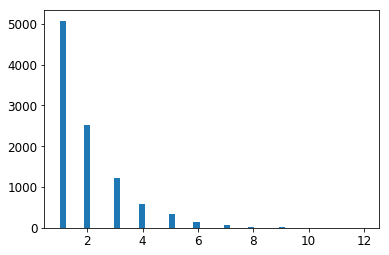

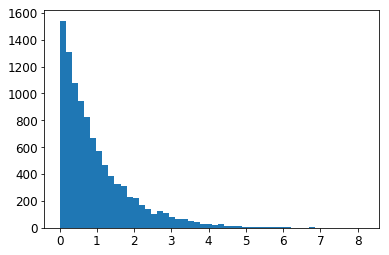

In [116]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Exercise solutions

## 1.

Question: Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

In [117]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  9.4min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 15.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]}, {'kernel': ['rbf'], 'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [118]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70363.90313964167

That's much worse than the `RandomForestRegressor`. Let's check the best hyperparameters found:

In [119]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

## 2.

Question: Try replacing `GridSearchCV` with `RandomizedSearchCV`.

In [120]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 12.1min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 19.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=4,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13a243278>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13a243e48>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [121]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54767.99053704408

Now this is much closer to the performance of the `RandomForestRegressor` (but not quite there yet). Let's check the best hyperparameters found:

In [122]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the exponential distribution we used, with `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

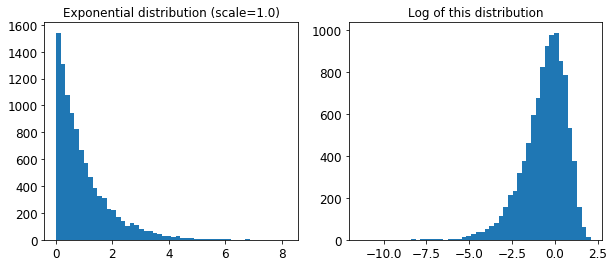

In [123]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for `C` looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

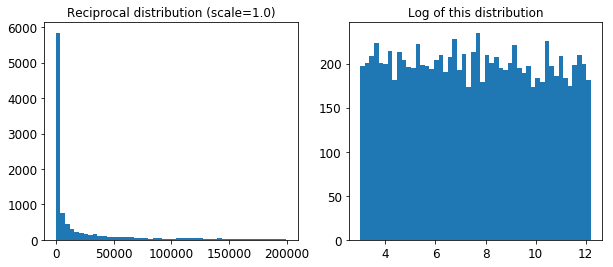

In [124]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

## 3.

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [125]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [126]:
k = 5

Now let's look for the indices of the top k features:

In [127]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12])

In [128]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

Let's double check that these are indeed the top k features:

In [129]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude')]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [130]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [131]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [132]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Now let's double check that these are indeed the top k features:

In [133]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Works great!  :)

## 4.

Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [134]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [135]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=1, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

Let's try the full pipeline on a few instances:

In [136]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [203214.28978849 371846.88152572 173295.65441612  47328.3970888 ]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best `RandomForestRegressor` that we found earlier, rather than the best `SVR`.

## 5.

Question: Automatically explore some preparation options using `GridSearchCV`.

In [137]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  9.7min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 19.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=1, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'], 'feature_selection__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [138]:
grid_search_prep.best_params_

{'feature_selection__k': 15,
 'preparation__num__imputer__strategy': 'most_frequent'}

The best imputer strategy is `most_frequent` and apparently almost all features are useful (15 out of 16). The last one (`ISLAND`) seems to just add some noise.

Congratulations! You already know quite a lot about Machine Learning. :)

In [ ]:
#How to apply linear regression to one dimensional data

In [129]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

In [142]:
# even for one column parameters we need to pass a two dimensional array
X = [[x] for x in range(10)]
X

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]

In [131]:
y = [x*1.5 + 3 for x in X]

In [133]:
# so X is train data and y is train labels

In [134]:
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [137]:
lin_reg.predict([[20],[30],[100]])

array([ 33.,  48., 153.])

In [140]:
lin_reg.intercept_

3.0000000000000027

In [141]:
lin_reg.coef_

array([1.5])

In [153]:
X = [[x, x*2+10] for x in range(10)]
X

[[0, 10],
 [1, 12],
 [2, 14],
 [3, 16],
 [4, 18],
 [5, 20],
 [6, 22],
 [7, 24],
 [8, 26],
 [9, 28]]

In [154]:
y = [x[0]*1.5 + x[1]*3.6 + 5 for x in X]

In [155]:
l_reg = LinearRegression()

In [156]:
l_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [157]:
l_reg.coef_

array([1.74, 3.48])

In [158]:
l_reg.intercept_

6.199999999999974

In [159]:
l_reg.predict([[10,10],[20,20],[100,100]])

array([ 58.4, 110.6, 528.2])

In [161]:
# here we would feed test data and test labels
l_reg.score(X, y)

1.0

In [ ]:
# simple linear regressor 
# https://towardsdatascience.com/linear-regression-in-6-lines-of-python-5e1d0cd05b8d